---
# Import Libraries

In [1]:
import os
import sys

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
sys.path.append("../../../deep-learning-dna")
sys.path.append("../")
sys.path.append("../../../deep-learning-dna/common")

In [4]:
import wandb

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import math
import string

from Attention import Set_Transformer
from common.models import dnabert
from common import dna
from lmdbm import Lmdb
from common.data import DnaSequenceGenerator, DnaLabelType, DnaSampleGenerator, find_dbs
import wandb

import tf_utils as tfu

In [6]:
strategy = tfu.devices.select_gpu(0, use_dynamic_memory=True)

---
# Load Data

## MNIST dataset

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [8]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [9]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


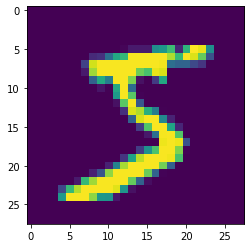

In [10]:
plt.imshow(x_train[0])

## MNIST Point Cloud Generation

In [11]:
class MnistPointCloudGenerator(keras.utils.Sequence):

    def __init__(self, x, y=None, num_points=1000, batch_size=32, threshold=70, shuffle=True, rng=None):
        self.x = x
        self.y = y.astype(np.int32) if y is not None else None
        self.num_points = num_points
        self.batch_size = batch_size if batch_size is not None else len(x)
        self.threshold = threshold
        self.should_shuffle = shuffle
        self.rng = rng if rng is not None else np.random.default_rng()

        self.num_batches = len(self.x) // self.batch_size

        self.init()
        self.shuffle()

    def init(self):
        img_ids, y_pixels, x_pixels = np.nonzero(self.x > self.threshold)
        self.pixels = (np.column_stack((x_pixels, 28 - y_pixels)) - 13.5) / 13.5
        _, self.pixel_counts = np.unique(img_ids, return_counts=True)
        self.pixel_offsets = np.concatenate(([0], np.cumsum(self.pixel_counts)))

    def shuffle(self):
        # Randomize the order of the images
        num_elems = self.num_batches*self.batch_size
        if self.shuffle:
            self.indices = np.reshape(self.rng.permutation(len(self.x))[:num_elems], (-1, self.batch_size))
        else:
            self.indices = np.reshape(np.arange(num_elems), (-1, self.batch_size))

        # Select random pixel indices
        noise = self.rng.uniform(size=(len(self.x), self.num_points))
        self.pixel_indices = (noise * np.reshape(self.pixel_counts, (-1, 1))).astype(np.int64) \
                           + np.reshape(self.pixel_offsets[:-1], (-1, 1))

        # Generate noise for the pixels
        self.pixel_noise = self.rng.normal(size=(len(self.x), self.num_points, 2), scale=1/13.5/2)

    def __len__(self):
        return self.num_batches

    def __getitem__(self, batch_index):
        indices = self.indices[batch_index]
        batch_x = self.pixels[self.pixel_indices[indices]] + self.pixel_noise[indices]
        if self.y is not None:
            return batch_x, self.y[indices]
        return batch_x

    def on_epoch_end(self):
        self.shuffle()

In [12]:
dataset = MnistPointCloudGenerator(x_train, y_train)

In [13]:
point_clouds, labels = dataset[0] # fetch a batch
print(point_clouds.shape, labels.shape)

(32, 1000, 2) (32,)


The digit is a 8


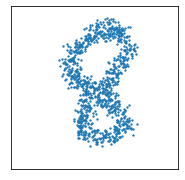

In [14]:
index = 1 # the index of the batch to show

print("The digit is a", labels[index])

plt.figure(figsize=(3, 3))
plt.scatter(*point_clouds[index].T, s=1.7)
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.xticks([])
plt.yticks([])
plt.show()

---
# Cache Memory

In [15]:
def Cache_Memory(current_state, previous_state, memory_length):
    
    if memory_length is None or memory_length == 0:
        return None
    else:
        if previous_state is None:
            new_mem = current_state[:, -memory_length:, :]
        else:
            new_mem = tf.concat(
                    [previous_state, current_state], 1)[:, -memory_length:, :]

    return tf.stop_gradient(new_mem)

---
# Attention

In [16]:
class Attention(keras.Model):
    def __init__(self, num_induce, embed_dim, num_heads, use_layernorm, pre_layernorm, use_keras_mha):
        super(Attention, self).__init__()
        
        self.num_induce = num_induce
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.use_layernorm = use_layernorm
        self.pre_layernorm = pre_layernorm
        self.use_keras_mha = use_keras_mha
        
        if self.num_induce == 0:       
            self.attention = (Set_Transformer.SetAttentionBlock(embed_dim=self.embed_dim, num_heads=self.num_heads, use_layernorm=self.use_layernorm,pre_layernorm=self.pre_layernorm,use_keras_mha=self.use_keras_mha))
        else:
            self.attention = Set_Transformer.InducedSetAttentionBlock(embed_dim=self.embed_dim, num_heads=self.num_heads, num_induce=self.num_induce, use_layernorm=self.use_layernorm, pre_layernorm=self.pre_layernorm, use_keras_mha=self.use_keras_mha)
    
    
    def call(self, data, mems):
                
            attention = self.attention([data, mems])
                
            return attention

---
# XL Block

In [17]:
class TransformerXLBlock(tf.keras.layers.Layer):
    def __init__(self,
                 num_induce, 
                 embed_dim,
                 num_heads,
                 use_layernorm,
                 pre_layernorm,
                 use_keras_mha,):

        super(TransformerXLBlock, self).__init__()
        
        self.num_induce = num_induce
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.use_layernorm = use_layernorm
        self.pre_layernorm = pre_layernorm
        self.use_keras_mha = use_keras_mha
        
        self.attention = Attention
        
        self.attention_layer = self.attention(self.num_induce, self.embed_dim, self.num_heads, self.use_layernorm, self.pre_layernorm, self.use_keras_mha)

   
    def call(self,
             content_stream,
             state=None):
        
        attention_output = self.attention_layer(content_stream, state)

        return attention_output

---
# Transformer XL

In [18]:
class TransformerXL(tf.keras.layers.Layer):
    def __init__(self,
                 mem_switched, 
                 num_layers,
                 num_induce,
                 embed_dim,
                 num_heads,
                 dropout_rate,
                 mem_len=None,
                 use_layernorm=True,
                 pre_layernorm=True, 
                 use_keras_mha=True):
        
        super(TransformerXL, self).__init__()

        self.mem_switched = mem_switched
        self.num_layers = num_layers
        self.num_induce = num_induce
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.mem_len = mem_len
        self.use_layernorm = use_layernorm
        self.pre_layernorm = pre_layernorm
        self.use_keras_mha = use_keras_mha

        self.transformer_xl_layers = []
        
        for i in range(self.num_layers):
            self.transformer_xl_layers.append(
                    TransformerXLBlock(self.num_induce,
                                        self.embed_dim,
                                        self.num_heads,
                                        self.use_layernorm,
                                        self.pre_layernorm, 
                                        self.use_keras_mha))

        self.output_dropout = tf.keras.layers.Dropout(rate=self.dropout_rate)

    def call(self,
             content_stream,
             state=None):
        
        new_mems = []

        if state is None:
            state = [None] * self.num_layers
            
        for i in range(self.num_layers):
            if self.mem_switched == False:
                new_mems.append(Cache_Memory(content_stream, state[i], self.mem_len))
            
            transformer_xl_layer = self.transformer_xl_layers[i]
            
            transformer_xl_output = transformer_xl_layer(content_stream=content_stream,
                                                        state=state[i])
            
            content_stream = self.output_dropout(transformer_xl_output)
            
            if self.mem_switched == True:
                new_mems.append(Cache_Memory(content_stream, state[i], self.mem_len))

        output_stream = content_stream
        return output_stream, new_mems

---
# Xl Model Class

In [19]:
class XlModel(keras.Model):
    def __init__(self, mem_switched, max_files, encoder, block_size, max_set_len, num_induce, embed_dim, num_layers, num_heads, mem_len, dropout_rate, num_seeds, use_layernorm, pre_layernorm, use_keras_mha):
        super(XlModel, self).__init__()
        
        self.mem_switched = mem_switched
        self.max_files = max_files
        self.encoder = encoder
        self.block_size = block_size
        self.max_set_len = max_set_len
        self.num_induce = num_induce
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.mem_len = mem_len
        self.dropout_rate = dropout_rate
        self.num_seeds = num_seeds
        self.use_layernorm = use_layernorm
        self.pre_layernorm = pre_layernorm
        self.use_keras_mha = use_keras_mha
        
        self.linear_layer = keras.layers.Dense(self.embed_dim)
        
        self.transformer_xl = TransformerXL(self.mem_switched,
                                            self.num_layers,
                                             self.num_induce,
                                             self.embed_dim,
                                             self.num_heads,
                                             self.dropout_rate,
                                             self.mem_len,
                                             self.use_layernorm,
                                             self.pre_layernorm,
                                             self.use_keras_mha)
        

        self.pooling_layer = Set_Transformer.PoolingByMultiHeadAttention(num_seeds=self.num_seeds,embed_dim=self.embed_dim,num_heads=self.num_heads,use_layernorm=self.use_layernorm,pre_layernorm=self.pre_layernorm, use_keras_mha=self.use_keras_mha, is_final_block=True)
    
        self.reshape_layer = keras.layers.Reshape((embed_dim,))
        
        self.dropout_layer = keras.layers.Dropout(.5)
        
        self.dense_layer = keras.layers.Dense(10)                                       

    def call(self, x, training=None):    
 
        mems = tf.zeros((self.num_layers, tf.shape(x)[0], self.mem_len, self.embed_dim))
        
        linear_transform = self.linear_layer(x)

        for i in range(0, self.max_set_len, self.block_size):

            block = linear_transform[:,i:i+self.block_size]
            
            output, mems = self.transformer_xl(content_stream=block, state=mems)

        pooling = self.pooling_layer(output)

        dropout = self.dropout_layer(pooling)

        reshape = self.reshape_layer(dropout)

        output = self.dense_layer(reshape)       
        
        return output

---
# Xl Parameters

In [20]:
#Xl Parameters
max_files = 0
encoder = 0
mem_switched = True
num_induce = 10
embed_dim = 64
num_layers = 4
num_heads = 4
mem_len = 200
dropout_rate = 0.01
num_seeds = 1
use_layernorm = True
pre_layernorm = True
use_keras_mha = True

---
## 1000-Element Point Clouds

### Dataset

In [21]:
split_index = int(0.2*len(x_train))

train_dataset = MnistPointCloudGenerator(x_train[split_index:], y_train[split_index:], num_points=1000)
val_dataset = MnistPointCloudGenerator(x_train[:split_index], y_train[:split_index], num_points=1000)
test_dataset = MnistPointCloudGenerator(x_test, y_test, num_points=1000)


---
# Create Models

In [22]:
block_size = 200

In [23]:
max_set_len = 1000
set_len = 1000

In [24]:
model = XlModel(mem_switched, max_files, encoder, block_size, max_set_len, num_induce, embed_dim, num_layers, num_heads, mem_len, dropout_rate, num_seeds, use_layernorm, pre_layernorm, use_keras_mha)
model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

In [34]:
tf.argmax(model.predict(train_dataset[0][0]), -1)

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([5, 1, 2, 3, 0, 6, 3, 9, 9, 1, 0, 4, 7, 5, 7, 2, 9, 5, 2, 0, 6, 4,
       8, 1, 0, 3, 6, 3, 2, 4, 7, 6])>

In [35]:
train_dataset[0][1]

array([5, 1, 2, 3, 0, 6, 3, 9, 9, 1, 0, 4, 7, 5, 7, 7, 4, 5, 2, 0, 6, 4,
       8, 1, 0, 8, 6, 3, 2, 4, 7, 4], dtype=int32)

In [32]:
epochs = 20

In [33]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/20
1500/1500 [==============================] - 179s 119ms/step - loss: 1.4870 - sparse_categorical_accuracy: 0.4661 - val_loss: 0.7950 - val_sparse_categorical_accuracy: 0.7280
Epoch 2/20
1500/1500 [==============================] - 194s 129ms/step - loss: 0.6692 - sparse_categorical_accuracy: 0.7852 - val_loss: 0.4082 - val_sparse_categorical_accuracy: 0.8738
Epoch 3/20
  16/1500 [..............................] - ETA: 2:24 - loss: 0.4972 - sparse_categorical_accuracy: 0.8516

KeyboardInterrupt: 